---

# Deep Computer Vision with Convolutional Neural Network

In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt

In [3]:
import matplotlib as mpl

In [4]:
import tensorflow as tf

In [5]:
from tensorflow import keras

In [6]:
# function for plotting the gray image

def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

In [7]:
# function for plotting the  color image

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

In [8]:
from sklearn.datasets import load_sample_image

In [9]:
# Load sample images

# the pixel intensity of each color in these images is from 0 to 255, so we divided the image with 255 to 
 # scale the whole images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

In [10]:
# creating the two filters manually

# Create 2 filters

# Then we create two 7 × 7 filters (one with a vertical white line in the middle,
 # and the other with a horizontal white line in the middle).


filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

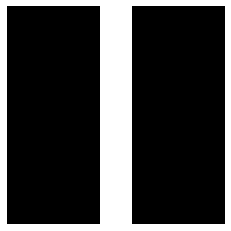

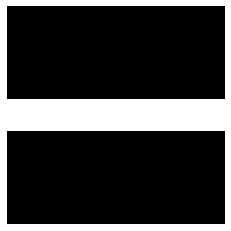

In [11]:
# checking the image filters

plot_image(filters[:, :, 0, 0])
plt.show()


plot_image(filters[:, :, 0, 1])
plt.show()

In [12]:
filters.shape

(7, 7, 3, 2)

In [13]:
# applying the filters using tf.nn.conv2d which is the part of tensorlfow low level api

# images is the input mini batch, a 4D tensor

# In case of padding = 'SAME' Convolution layer used 'zero' padding around the height and width of the image
# This way some part of the image will not be missed else while striding some part of the image may get skipped.
 # Size of the feature map will be round(image_size/strides) in that direction
outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

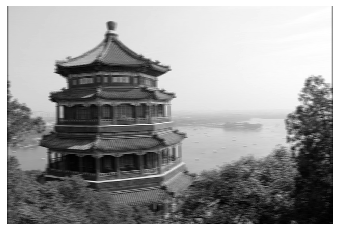

In [14]:

plt.imshow(outputs[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map
plt.axis("off") # Not shown in the book
plt.show()

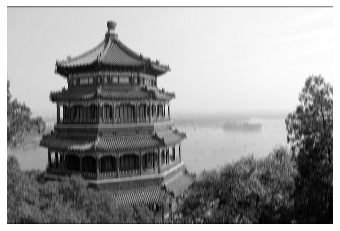

In [22]:
# plotted the 1st image's 1st feature map

plt.imshow(outputs[0, :, :, 0], cmap="gray")
plt.axis("off") # Not shown in the book
plt.show()

---

# Convolution Layer

Using keras.layers.Conv2D():

In [ ]:
# This code creates a convolutional 2D layer using 32 filters

# Applying the ReLU activation function to it's outputs
conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1,
                           padding="SAME", activation="relu")

---

# Pooling Layer

---

### Max Pooling

In [28]:
def crop(images):
    return images[150:220, 130:250]

In [26]:
max_pool = keras.layers.MaxPool2D(pool_size=2)

In [29]:

# cropping the image
cropped_images = np.array([crop(image) for image in images], dtype=np.float32)

# output after using maxpool
output = max_pool(cropped_images)

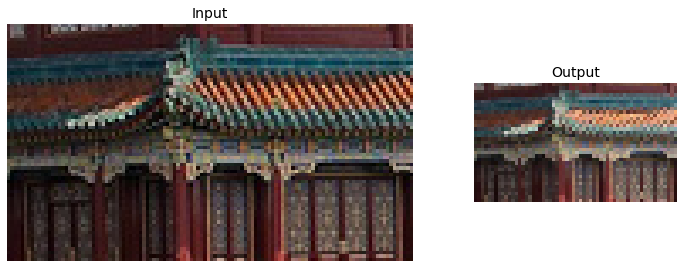

In [31]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

# for plotting the image after the cropping
ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")

# for plotting the output after implementing the max pooling 
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")

plt.show()

---

### Depth Wise Pooling 

In [32]:
class DepthMaxPool(keras.layers.Layer):
    def __init__(self, pool_size, strides=None, padding="VALID", **kwargs):
        super().__init__(**kwargs)
        if strides is None:
            strides = pool_size
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding
    def call(self, inputs):
        return tf.nn.max_pool(inputs,
                              ksize=(1, 1, 1, self.pool_size),
                              strides=(1, 1, 1, self.pool_size),
                              padding=self.padding)

In [33]:
# using with lambda 

depth_pool = keras.layers.Lambda(lambda X: tf.nn.max_pool(
    X, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3), padding="VALID"))
with tf.device("/cpu:0"): # there is no GPU-kernel yet
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

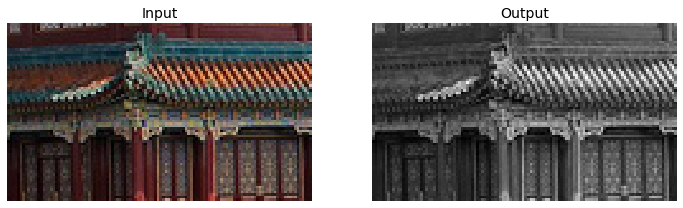

In [34]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input", fontsize=14)
plot_color_image(cropped_images[0])  # plot the 1st image
plt.subplot(1, 2, 2)
plt.title("Output", fontsize=14)
plot_image(depth_output[0, ..., 0])  # plot the output for the 1st image
plt.axis("off")
plt.show()

---

### Average Pooling 



In [35]:
avg_pool = keras.layers.AvgPool2D(pool_size=2)

In [36]:
output_avg = avg_pool(cropped_images)

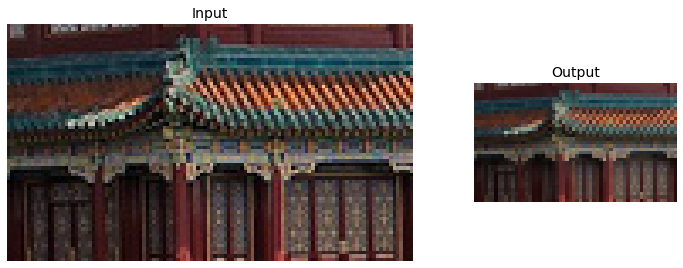

In [37]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output_avg[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

---

# Convolutional Neural Network for Tackling MNIST dataset

In [38]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [39]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    
    # input size is 28 x 28 with single channel because of grayscale
    
    # Note that the number of filters grows as we climb up the CNN toward the output layer 
     # (it is initially 64, then 128, then 256): it makes sense for it to grow, since the number of low-level
      # features is often fairly low.

    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

In [40]:
# It will take a lot of time to run it, so try it on google colab

model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10] # pretend we have new images
y_pred = model.predict(X_new)

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 285s 5ms/sample - loss: 0.6931 - accuracy: 0.7591 - val_loss: 0.3614 - val_accuracy: 0.8734
Epoch 2/10
55000/55000 [==============================] - 287s 5ms/sample - loss: 0.4140 - accuracy: 0.8608 - val_loss: 0.3089 - val_accuracy: 0.8830
Epoch 3/10
55000/55000 [==============================] - 276s 5ms/sample - loss: 0.3591 - accuracy: 0.8798 - val_loss: 0.3091 - val_accuracy: 0.8930
Epoch 4/10
55000/55000 [==============================] - 295s 5ms/sample - loss: 0.3336 - accuracy: 0.8868 - val_loss: 0.2905 - val_accuracy: 0.8942
Epoch 5/10
55000/55000 [==============================] - 300s 5ms/sample - loss: 0.3118 - accuracy: 0.8953 - val_loss: 0.3136 - val_accuracy: 0.8906
Epoch 6/10
55000/55000 [==============================] - 302s 5ms/sample - loss: 0.2915 - accuracy: 0.9021 - val_loss: 0.3106 - val_accuracy: 0.8892
Epoch 7/10
55000/55000 [===========================

# END